# Create Data

In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt

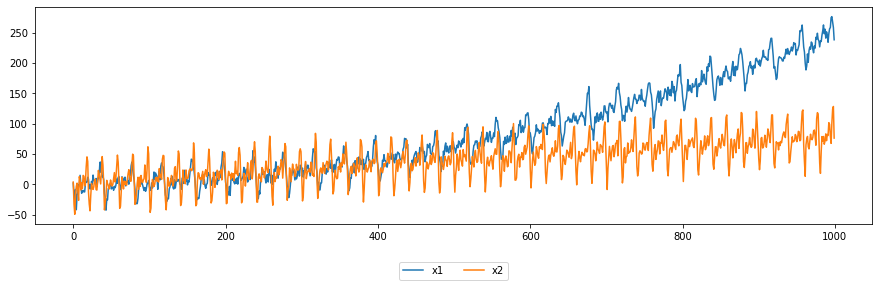

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([10*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [3]:
x_index = np.array(range(len(t)))

In [4]:
print('correlation between x1 and x2: {}'.format(spearmanr(x1, x2)))

correlation between x1 and x2: SpearmanrResult(correlation=0.7850750210750211, pvalue=7.849181976375316e-210)


# Prepare Data

### Detrend

In [5]:
# assume we already know the order of trend
x1_trend_param = np.polyfit(x_index, x1, 2)
x2_trend_param = np.polyfit(x_index, x2, 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.48104908e-04  9.16861131e-04 -8.68470795e-01]
[ 0.08043379 -0.95179361]


In [6]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

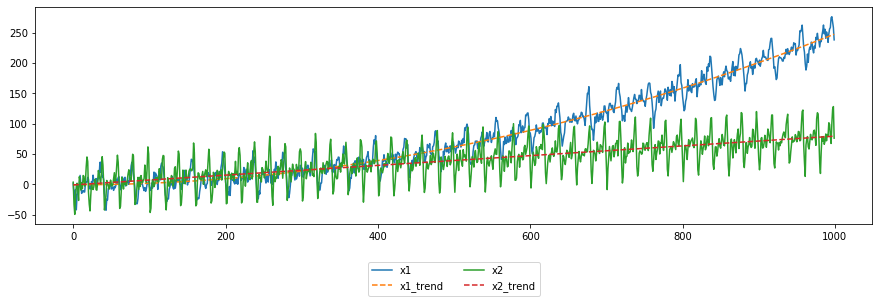

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')

plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

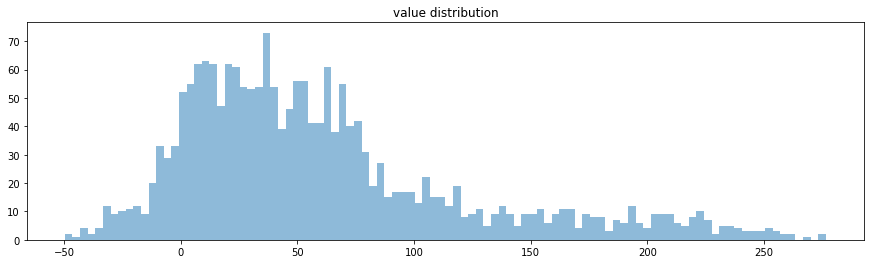

In [8]:
plt.figure(figsize=(15, 4))
plt.hist(np.column_stack([x1, x2]).flatten(), bins=100, alpha=0.5)
plt.title('value distribution')
plt.show()

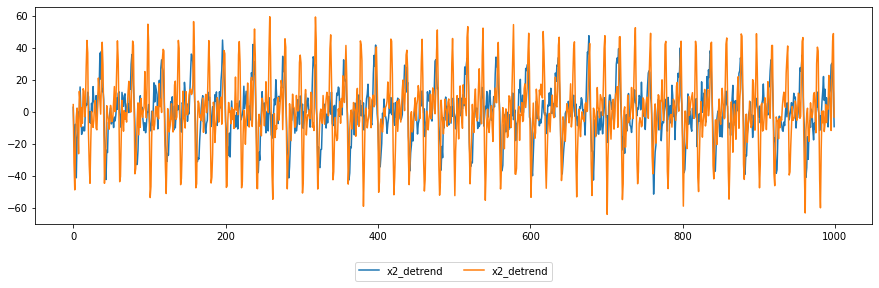

In [9]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Split

In [10]:
train_ratio = 0.8
train_len = int(train_ratio*x_index.shape[0])
print(train_len)

800


In [11]:
# x_lbl columns: ===================
# columns1: detrended x1, 
# columns2: detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  2.82019096   4.49476022   0.           1.        ]
 [-15.85850193 -31.92353245   1.           1.        ]
 [-25.02156773 -48.85737133   2.           1.        ]
 ...
 [ 20.79783245  44.48657132 997.           0.        ]
 [ 11.51618336  48.94435324 998.           0.        ]
 [ -9.30021791  -3.28583629 999.           0.        ]]


### Normalize

In [12]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[47.60701226829747, 59.477532479363774, 1, 1]


In [13]:
# x_lbl columns: ===================
# columns1: normalized detrended x1, 
# columns2: normalized detrended x2, 
# columns3: index
# columns4: 1 for train set, 0 for test set

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 5.92389823e-02  7.55707245e-02  0.00000000e+00  1.00000000e+00]
 [-3.33112732e-01 -5.36732630e-01  1.00000000e+00  1.00000000e+00]
 [-5.25585760e-01 -8.21442472e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 4.36864896e-01  7.47955900e-01  9.97000000e+02  0.00000000e+00]
 [ 2.41900989e-01  8.22904905e-01  9.98000000e+02  0.00000000e+00]
 [-1.95353950e-01 -5.52450001e-02  9.99000000e+02  0.00000000e+00]]


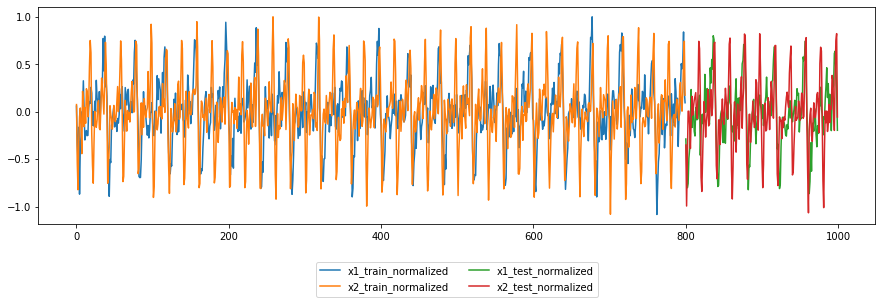

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Truncate

In [15]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
    

In [16]:
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [17]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]

X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/Luong%20Attention.png?raw=true)

In [18]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot, Lambda
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [19]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [20]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm_1/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm_1/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_1/while:5", shape=(None, 100), dtype=float32)


In [21]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
print(encoder_last_h)

Tensor("batch_normalization_1/cond/Identity:0", shape=(None, 100), dtype=float32)


In [22]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)


In [23]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_2/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [24]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_1/truediv:0", shape=(None, 20, 200), dtype=float32)


In [25]:
context = dot([attention, encoder_stack_h], axes=[2,1])
print(context)

Tensor("dot_2/MatMul:0", shape=(None, 20, 100), dtype=float32)


In [26]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate_1/concat:0", shape=(None, 20, 200), dtype=float32)


In [27]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [28]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 2)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 100), ( 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         lstm_1[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

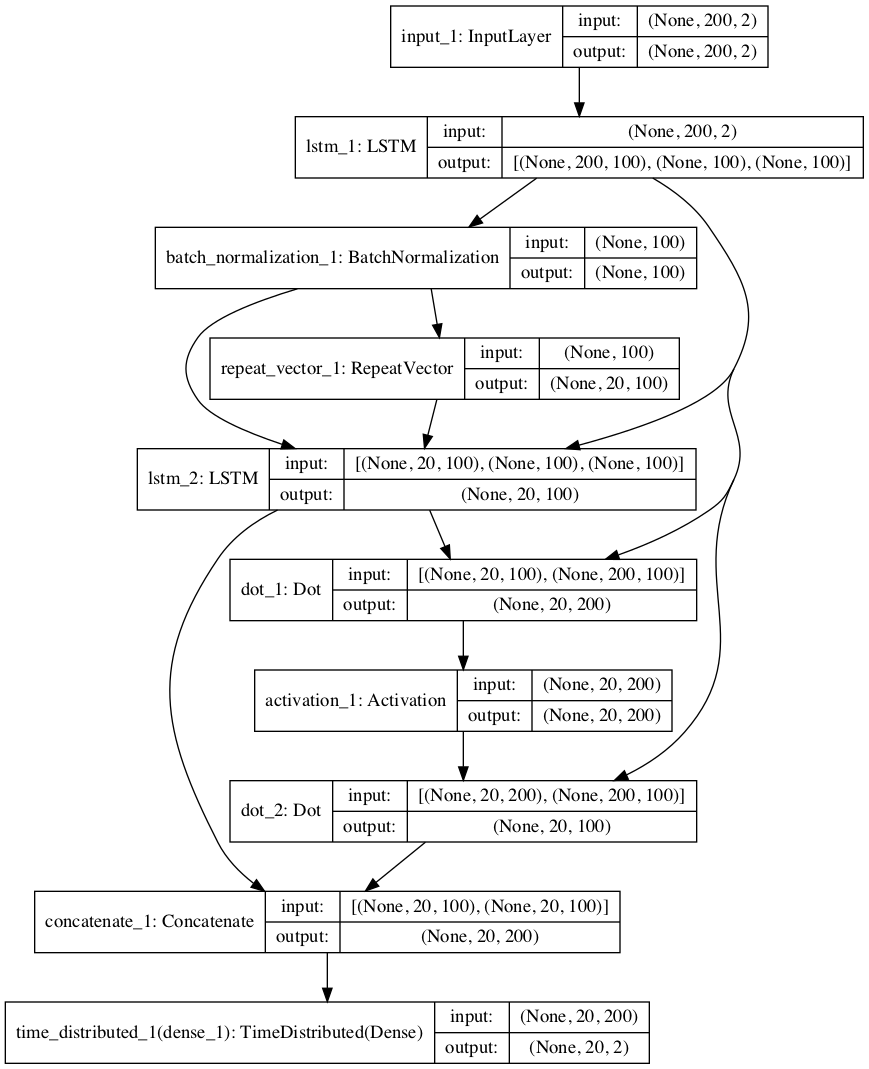

In [29]:
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
epc = 110
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('model_forecasting_demo.h5')

Train on 480 samples, validate on 120 samples
Epoch 1/110
480/480 [==============================] - 3s 6ms/step - loss: 3.0049 - mae: 0.7906 - val_loss: 0.1241 - val_mae: 0.2581
Epoch 2/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1709 - mae: 0.3118 - val_loss: 0.1303 - val_mae: 0.2649
Epoch 3/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1325 - mae: 0.2704 - val_loss: 0.1199 - val_mae: 0.2539
Epoch 4/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1228 - mae: 0.2579 - val_loss: 0.1179 - val_mae: 0.2503
Epoch 5/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1190 - mae: 0.2520 - val_loss: 0.1145 - val_mae: 0.2473
Epoch 6/110
480/480 [==============================] - 2s 4ms/step - loss: 0.1163 - mae: 0.2500 - val_loss: 0.1111 - val_mae: 0.2441
Epoch 7/110
480/480 [==============================] - 2s 5ms/step - loss: 0.1128 - mae: 0.2459 - val_loss: 0.1077 - val_mae: 0.2405
Epoch 8/110
480/480 [==

Epoch 62/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0426 - mae: 0.1547 - val_loss: 0.0305 - val_mae: 0.1362
Epoch 63/110
480/480 [==============================] - 2s 4ms/step - loss: 0.0420 - mae: 0.1529 - val_loss: 0.0260 - val_mae: 0.1253
Epoch 64/110
480/480 [==============================] - 3s 6ms/step - loss: 0.0354 - mae: 0.1423 - val_loss: 0.0293 - val_mae: 0.1334
Epoch 65/110
480/480 [==============================] - 3s 7ms/step - loss: 0.0363 - mae: 0.1427 - val_loss: 0.0244 - val_mae: 0.1224
Epoch 66/110
480/480 [==============================] - 3s 6ms/step - loss: 0.0365 - mae: 0.1428 - val_loss: 0.0324 - val_mae: 0.1371
Epoch 67/110
480/480 [==============================] - 3s 6ms/step - loss: 0.0393 - mae: 0.1474 - val_loss: 0.0326 - val_mae: 0.1400
Epoch 68/110
480/480 [==============================] - 2s 5ms/step - loss: 0.0405 - mae: 0.1484 - val_loss: 0.0276 - val_mae: 0.1313
Epoch 69/110
480/480 [==============================] - 2s 4ms

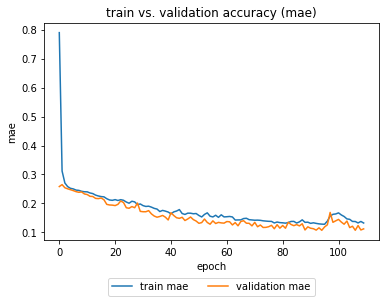

In [31]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [32]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [33]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [34]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [35]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
190.19573202204776
maximum: train_true
197.46978879246998
maximum: test_pred
279.27122633646735
maximum: test_true
276.5420724851176


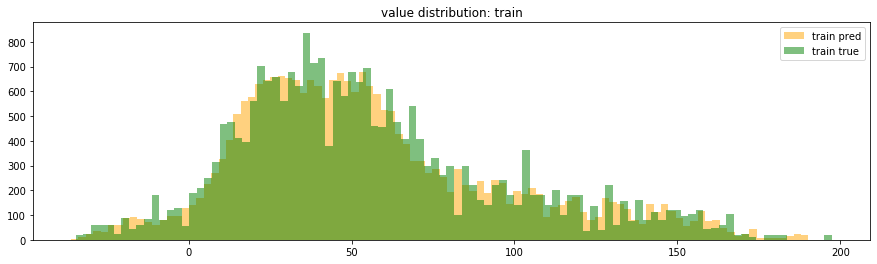

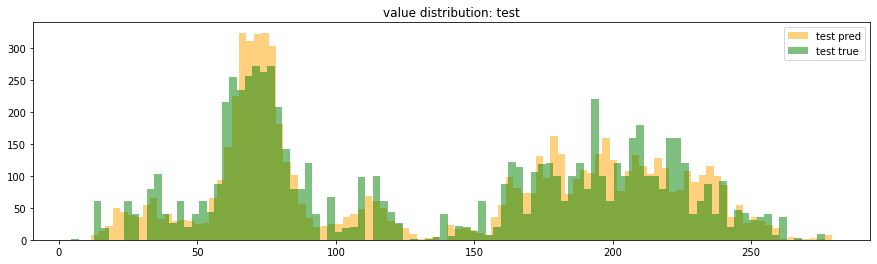

In [36]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

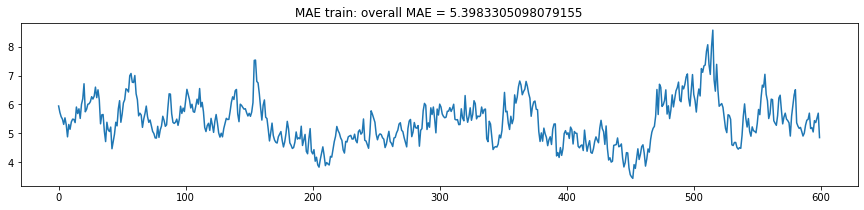

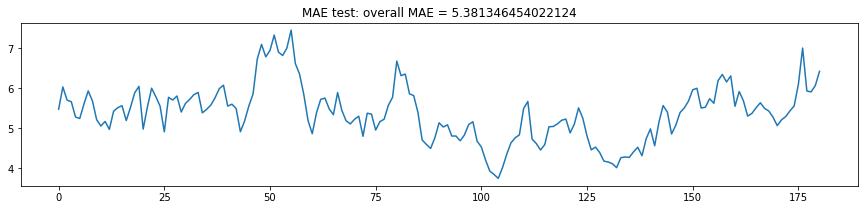

In [37]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

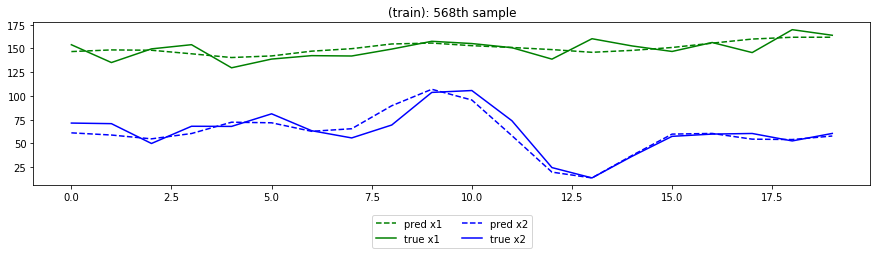

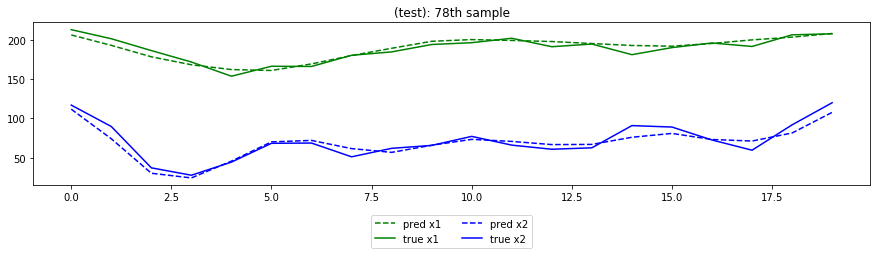

In [38]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()



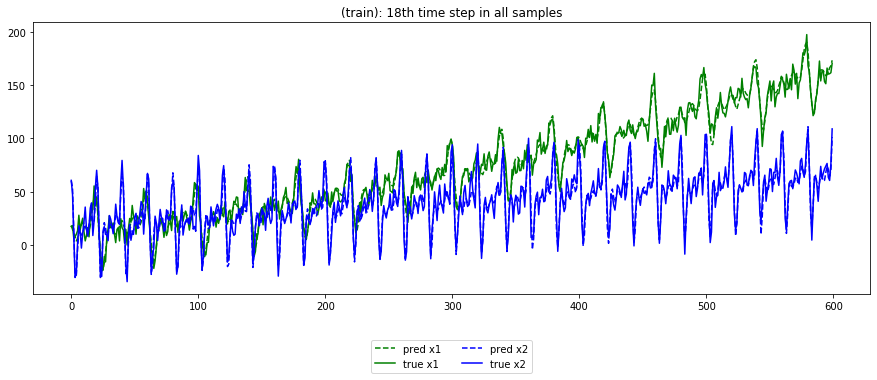

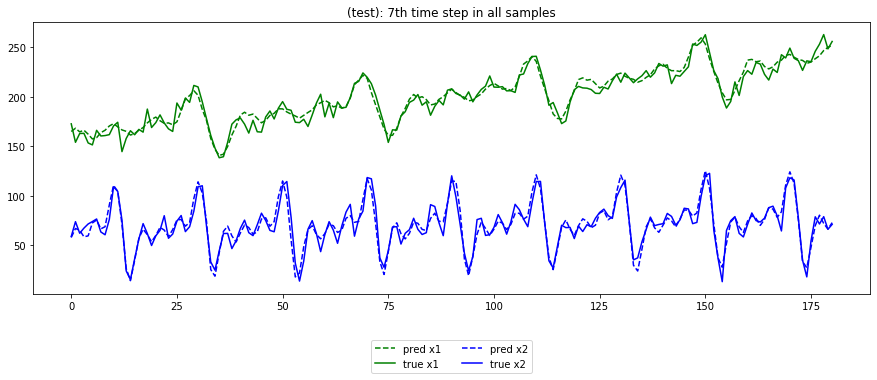

In [39]:
for lb in ['train', 'test']:
    ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()
